In [1]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
#  импорт данных
hw_aa = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')
hw_aa

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [6]:
# просмотр типа данных
hw_aa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


In [8]:
# проверка на пропущенные значения
hw_aa.isnull().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [9]:
hw_aa.sort_values('purchase')

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
83817,83818,26b764a8f77b0da8349b90ab894a8fcd,1,v2.9.0,0
83816,83817,338e130702fa4b338433cd37b1a5a5a0,1,v2.8.0,0
83815,83816,6475199a00c44f974f2f0aa2a33377f6,1,v2.8.0,0
83814,83815,34e6242f2a8d9960c35d15aa64ddf592,0,v2.8.0,0
...,...,...,...,...,...
25374,25375,262717604b93578b7309e4a57fe91447,0,v2.9.0,1
70129,70130,7a776ddb3d2a19cb3b8dea3add863f29,1,v2.9.0,1
70130,70131,5ac0275858fa1f706d8550ae0828a016,1,v2.8.0,1
86558,86559,e2a9357949811bf87116c93470031d72,1,v2.8.0,1


In [34]:
# делим на группы:
df_group_0 = hw_aa \
    .query('experimentVariant == 0')
df_group_1 = hw_aa \
    .query('experimentVariant == 1')
# посмотрим на размер групп
df_group_0.shape

(63102, 5)

In [35]:
df_group_1.shape
#  размер различается!!! ~ 1.3%

(63916, 5)

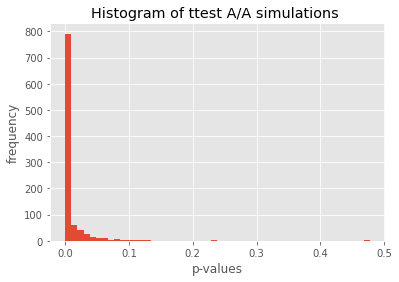

F P R   =   0 . 9 3 6


In [36]:
#  АА-тест

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s0 = df_group_0['purchase'].sample(n_s, replace = False).values
    s1 = df_group_1['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s0, s1, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('p-values')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
out = 'FPR = {}'.format(sum(np.array(res) <0.05) / simulations)
print(*out)

Как видно из рисунка выше, распределение p-value н равномерное, с ярко выраженным максимумом смещенным в сторону малых значений p-value. Кроме того значение FPR >> 0,05. Все это указывает на поломку системы сплитования.

Наиболее частые причины:
- долгое ожидание ответа сервера  по присвоению experimentVariant - **нет данных**;
- не на всех страницах/кейсах реализован алгоритм - **нет данных**;
- "сломан" рандом - - **нет данных**;
- приоритет той или иной группе - **можно поискать**.

У каждого пользователя нам известна версия приложния, которой он пользовался. Посмотрим как распределены пользователи по этим приложениям внутри групп:

In [54]:
group_difference = hw_aa \
    .groupby(['experimentVariant', 'version']) \
    .agg({'uid' : 'count'}) \
    .rename(columns = {'uid' : 'count_uid'}) \
    .unstack('experimentVariant') \
    .reset_index() \
    .rename(columns = {0 : 'group_0', 1 : 'group_1'})
group_difference

version count_uid        
experimentVariant             group_0 group_1
0                    v2.8.0     41283   41552
1                    v2.9.0     11921   12033
2                  v3.7.4.0      4204    4221
3                  v3.8.0.0      5694    6110

In [55]:
#  посчитаем % каждой версии приложения в каждой группе от общего количества пользователей в группе
group_difference['app_perc_0_all_uid'] = group_difference.count_uid.group_0/df_group_0.shape[0]*100
group_difference['app_perc_1_all_uid'] = group_difference.count_uid.group_1/df_group_1.shape[0]*100
#  и абсолютную и относительную (в%) разницу между количеством пользователей в группах, пользующихся одно версией приложения
group_difference['diff'] = group_difference.count_uid.group_0 - group_difference.count_uid.group_1
group_difference['diff_perc'] = group_difference.app_perc_0_all_uid - group_difference.app_perc_1_all_uid
group_difference

version count_uid         app_perc_0_all_uid  \
experimentVariant             group_0 group_1                      
0                    v2.8.0     41283   41552          65.422649   
1                    v2.9.0     11921   12033          18.891636   
2                  v3.7.4.0      4204    4221           6.662229   
3                  v3.8.0.0      5694    6110           9.023486   

                  app_perc_1_all_uid diff diff_perc  
experimentVariant                                    
0                          65.010326 -269  0.412323  
1                          18.826272 -112  0.065364  
2                           6.603980  -17  0.058249  
3                           9.559422 -416 -0.535936

При сравнении % каждой версии приложения в каждой группе видно, что как будто они слабо отличаются в каждой группе и разница между ними не велика. 

Наибольшая абсолютная разница 

Давайте посмотрим сколько в % составляет разница в количестве пользователей между группами пользующимися одним приложением отнесенная усредненному количеству пользователей данной версии приложения:

In [59]:
group_difference['diff_perc_app_uid'] = ((group_difference.count_uid.group_0 - group_difference.count_uid.group_1)*2
                                             /(group_difference.count_uid.group_0 + group_difference.count_uid.group_1))*100
group_difference

version count_uid         app_perc_0_all_uid  \
experimentVariant             group_0 group_1                      
0                    v2.8.0     41283   41552          65.422649   
1                    v2.9.0     11921   12033          18.891636   
2                  v3.7.4.0      4204    4221           6.662229   
3                  v3.8.0.0      5694    6110           9.023486   

                  app_perc_1_all_uid diff diff_perc diff_perc_app_uid  
experimentVariant                                                      
0                          65.010326 -269  0.412323         -0.649484  
1                          18.826272 -112  0.065364         -0.935126  
2                           6.603980  -17  0.058249         -0.403561  
3                           9.559422 -416 -0.535936         -7.048458

Колонка **diff** показыввает абсолютную разницу в количестве пользователей между группами каждой версии приложения. Она максимальна для версий v2.8.0 и v3.8.0.0. Тем не менее стоит отметить, что первое приложение - наиболее популярное, а второе - наименее популярное, как в первой так и второй группе.

Колонка **perc_diff** показыввает относительную разницу между % каждого приложения в каждой группе. Максимальная разница также наблюдается для групп v2.8.0 и v3.8.0.0. 

Колонка **diff_perc_app_uid** показывает, насколько велика абсолютная разница в количестве пользователей между группами каждой версии приложения по отношению к усредненному количеству пользователей данной версии приложения. Как видно в этой колонке абсолютным "чемпионом", является версия v3.8.0.0 превосходя остальных более чем в 7 раз.

**Промежуточный вывод**: наибольшая абсолютная и относительная разница в количестве пользователей между группами наблюдается для версии приложния v3.8.0.0

In [62]:
#  Посмотрим насколько отличается конверсия в каждой версии приложения без разделения на группы
conversion_version_all = hw_aa \
    .groupby('version', as_index = False) \
    .agg({'purchase' : 'mean'}) \
    .rename(columns = {'purchase' : 'conversion_all'})
conversion_version_all

,version,conversion_all
0,v2.8.0,0.023372
1,v2.9.0,0.072973
2,v3.7.4.0,0.061484
3,v3.8.0.0,0.060319


In [65]:
#  и конверсия по версиям приложение с разделением на группы
  #  0 группа
conversion_version_0 = hw_aa \
    .query('experimentVariant == 0') \
    .groupby('version', as_index = False) \
    .agg({'purchase' : 'mean'}) \
    .rename(columns = {'purchase' : 'conversion_0'})
  #  1 группа
conversion_version_1 = hw_aa \
    .query('experimentVariant == 1') \
    .groupby('version', as_index = False) \
    .agg({'purchase' : 'mean'}) \
    .rename(columns = {'purchase' : 'conversion_1'})

In [69]:
#  объединим созданные выше DF
conversion_version = conversion_version_all \
    .merge(conversion_version_0, how = 'inner', on = 'version') \
    .merge(conversion_version_1, how = 'inner', on = 'version')
conversion_version['diff_perc'] = (conversion_version.conversion_0 - conversion_version.conversion_1)/conversion_version.conversion_all*100
conversion_version

,version,conversion_all,conversion_0,conversion_1,diff_perc
0,v2.8.0,0.023372,0.000993,0.045606,-190.881455
1,v2.9.0,0.072973,0.074658,0.071304,4.596553
2,v3.7.4.0,0.061484,0.059943,0.063018,-5.001865
3,v3.8.0.0,0.060319,0.057604,0.062848,-8.692675


Таблица выше показывает конверсию по версиям приложения без разделения на группы (conversion_all), а также с разделением на группы 0 и 1 (conversion_0 и	conversion_1)

Видно, что конверсии между группами отличаются. для версий приложения v2.9.0, v3.7.4.0 и v3.8.0.0  различия значений не превышают 10%, в то время как для версии v2.8.0 составляют 190% !!!

Кроме того можно отметить, что пользователи использующие приложение v2.8.0 сотавляют подавляющее большинство от всех пользователей приложения

### Выводы

1. Есть **небольшая** проблема с размером двух групп. Количество пользователей в 1 группе ~1.3% больше чем в 0.
2. Наибольшие относительная разница наблюдаются для версии v3.8.0.0. и составляет 7% от среднего количества пользователей данного приложения в группе.  Но стоит отметить, что пользователи приложения данной версии составляют меньшинство среди всех пользователей, и поэтому, влияние данного фактора на систему сплитования как **среднее**.
3. Конверсия по пользователям, которые пользуются разными версиями приложения отличаются как при переходе от одной версии к другой, так и при переходе от одной группы к другой. Наибольшая относительная разница в конверсии по отношению к средней конверсии по версии приложения наблюдается для v2.8.0 и составляет 190%. Принимая во внимание, что пользователи версией v2.8.0 составляют абсолютное большинство от всех пользователей приложения я оцениваю влияние данного фактора как **наибольшее** и в первую очередь необходимо искать причины разницы между конверсиями по версиям приложения между группами.